## Introduction

In this part 3 of the series on Emotion Classifer miniproject, we are going to see how we can deploy the human emotion classifer to production and make a usuable front end for a customer. This is going to be the basic steps and not a full on production app. The [part1]({% post_url 2023-08-04-MiniProject_EmotionClassifer_Part1 %}) of this mini project series covers the basics of transfer learning while [part2]({% post_url 2023-08-09-MiniProject_EmotionClassifer_Part2 %}) covers augmenting and cleaning data.

We will accomplish the deployment of the trained model in three steps. First we will try loading the pickle file and running it locally. Second, we will use Notebook's builtin UI methods to write UI functions to interface between user and the notebook. Lastly, we will look at presenting this UI to the user.

**Initial Setup:**

We are repeating the required steps from part1 and part2 to setup the imports and functions required for this tutorial. If any of these code doesnt make sense to you, I suggest going back to part1 and part2 to review.

In [2]:
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.7 MB/s eta 0:00:00


In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *


Searching for 'smiling person face closeup'


/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


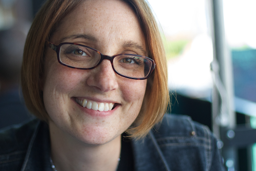

In [4]:
#download required classes & packages
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

#create method to search images
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

#search for image using keyword and download to destination
dest = 'happy.jpg'
download_url(search_images('smiling person face closeup', max_images=1)[0], dest, show_progress=False)

#finally open the image to show what we have
im = Image.open(dest)
im.to_thumb(256,256)

## STEP1: Loading the pickle file

In the previous [part2]({% post_url 2023-08-09-MiniProject_EmotionClassifer_Part2 %}) of this miniproject series, we had exported a pickle file at the last step. The pickle file is a persisted model that contains both the architecture and the trained parameters. The method also saves our definition of Dataloaders. Reason why this is important is we dont have to specify again on how to transform the input data when deploying this pickle file in production.

To use a pickle file, all we need to do is load the .pkl file and call the `predict()` on the model for inference. Simple as that!

Note: If you donot have a pickle file, please review the [part2]({% post_url 2023-08-09-MiniProject_EmotionClassifer_Part2 %}) of this miniproject.

Lets setup the basic for searching images using ddg_images. This is the same code as we had used in part1 and part2.

In [11]:
path = Path() #setup current path
learn_inf = load_learner(path/'export.pkl')

In [12]:
prediction_results = learn_inf.predict(path/'happy.jpg')

In [13]:
result_index = prediction_results[1]
print('predicted category:{}'.format(learn_inf.dls.vocab[result_index]))
print('predicted probability:{}'.format(prediction_results[2][result_index]))

predicted category:happy
predicted probability:0.9985558390617371


## STEP2: Create a Super Simple Notebook App

There are two important packages within the Python that will help us create FrontEnd UI like components.

* IPython widgets are GUI components that bring together JavaScript and Python functionality in a web browser, and can be created and used within a Jupyter notebook. This is similar to the UI we saw in Part 2 with the Data Cleaner function. FastAI uses IPython widgets behind the scenes to bring about the UI components. The downside is, users have to run jupyter notebooks. We dont want users to run Jupyter notebooks in order to access the app. That is why we have a second package, aptly named *Voila*!
* Voilà is a system for making applications consisting of IPython widgets available to end users, without them having to use Jupyter at all.

**Sample - Upload Button:**

Lets test out rendering Upload button GUI using IPythong Widgets. Code is super simple right?

In [35]:
#hide_output
import ipywidgets as widgets
from ipywidgets import *
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

**Sample - Uploaded Image:**

For the book, we can't actually click an upload button, so we fake it.

SimpleNamespace is a class provided by the types module in Python's standard library. It's a simple container class that allows you to create objects whose attributes can be assigned arbitrary values, similar to using a dictionary or a regular object, but with a more convenient syntax.



In [17]:
#hide_output
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['happy.jpg'])

Lets also render the uploaded image to see if we can view it.

In [20]:
img = PILImage.create(btn_upload.data[-1])

Instead of viewing the img directly, lets view the image through IPython widgets Output function.

In [21]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

**Sample - Predict Uploaded Image:**

Now that we can upload an image from a button, lets use the uploaded image to run prediction on our trained classifer.

In [24]:
pred,pred_idx,probs = learn_inf.predict(img)
probs = probs* 100

Instead of displaying the output in the normal Jupyter way lets display it using the IPythong Widgets.

In [27]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'I am {probs[pred_idx]:.02f}% sure that the image provided is a picture of a {pred} person'
lbl_pred

Label(value='I am 99.86% sure that the image provided is a picture of a happy person')

**Sample - Classify Image:**

For best UI Experience, we want the user to upload the image first using upload button and then hit on classify to run predictions. Lets build the classify button using IP widgets

In [31]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run


Button(description='Classify', style=ButtonStyle())

Also remember, we need to execute some logic to run when the button is pressed. Lets write a quick "On Click" function to run when user clicks on the button.

In [39]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1]) #convert the uploaded data to a PIL image.
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128)) # render uploaded image
    pred,pred_idx,probs = learn_inf.predict(img) #run prediction.
    probs = probs* 100
    lbl_pred.value = f'I am {probs[pred_idx]:.02f}% sure that the image provided is a picture of a {pred} person' #print label result

btn_run.on_click(on_click_classify)

**Sample - Putting it Together:**

Finally we can create a new upload button and arrange them all the UI components:
- The Title,
- The Upload Button,
- The Classify Button that has an associate onclick func,
- The Output Image
- The Output Prediction.

In [36]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [40]:
#hide_output
VBox([widgets.Label('====Human Emotion Classifer!===='), widgets.Label('Please upload a closeup picture of your face and let me try guessing your emotion'),
      btn_upload, btn_run, out_pl, lbl_pred])

## STEP3: Deploying the App

Ideally we should be creating a fresh notebook with only the required code to show the widgets we need. Take a look at [this notebook](https://github.com/VMLverse/HumanEmotionClassifer) in my repository.

After adding our widget code, we can run these two lines:
-  the first line installs the voila library and application
- and the second connects it to your existing Jupyter notebook.



In [ ]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila


Voilà runs Jupyter notebooks just like the Jupyter notebook server you are using now does, but it also does something very important: it removes all of the cell inputs, and only shows output (including ipywidgets), along with your markdown cells.

To view your notebook as a Voilà web application, replace the word "notebooks" in your browser's URL with: "voila/render". You will see the same content as your notebook, but without any of the code cells.

Note: If you are using colab or kaggle, you will not see "notebooks" in your URL. So it is not possible to accomplish this step.

###Deploying the App - Publically

The above step deploys your app locally. Others will not be able to see our app yet.

**Where do we host our app?**

To deploy publically, we can setup a server and run it. Or an easy way is to use some of the free hosting platforms to host our app and run it. (This is just a quick hobby project and we donot need anything fancy).

Binder offers a free hosting platform. We can use it to deploy our app publically. Here are the steps:

1. Add your notebook to a GitHub repository.
2. Paste the URL of that repo into Binder's URL, as shown in <>.
3. Change the File dropdown to instead select URL.
4. In the "URL to open" field, enter /voila/render/name.ipynb (replacing name with the name of for your notebook).
5. Click the clickboard button at the bottom right to copy the URL and paste it somewhere safe.
6. Click Launch.

**Do we need a GPU?**

We also only need a CPU since we will be sending one image at a time. If we had very large user traffic, we may need a GPU so we can collect images and process them in batch. Also there is no model training. So that is another case for not wanting a GPU.

## Closing Thoughts - Its Just an API!


Once you have exported your trained model, from that point it becomes a few lines of code to deploy it and have a front end UI for it. Any hosting technology and UI framework should work.

To avoid any dependencies, it would be best to host the machine learning interpretation on a server and expose an API. That way we could build any number of front end UIs across multiple devices and not have to worry about computing depencies for executing the inference and only worry about setting up the UI to interface with the customer.

## References
- Book: Howard, J., &amp; Gugger, S. (2021). Deep learning for coders with FASTAI and pytorch: AI applications without a Phd. O’Reilly Media, Inc. [link](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch-ebook-dp-B08C2KM7NR/dp/B08C2KM7NR)